# Train Localization
This notebook demonstrates train localization with Kalman Filter. We assume that a train is running on rail between stations. We can measure position of a train on the rail with several sensors and our goal is to estimate its position accurately. We will explore Kalman Filter for this task. 

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pandas as pd
from kalman_filter import KalmanFilter, TrainSimulator

## Experiment Settings
* Distance between stations: 10km 
* Maximum speed: 300 km/h
* Maximum acceleration/brake: 1.0 m/s$^2$
* Number of sensor: 3
* Measurement  accuracy: 3 m
* Measurement cycle: 100 ms
* Measurement delay: 10 ms
* Probability of outlier: 1%

## Kalman Filter with parameter update
* 2D KF states (position, speed)
* Fixed KF parameters

In [2]:
dt = 0.1
sig_w = 3.0
sig_v = 3.0
num_sensor = 3
sensor_delay = 0.01

F = np.array([[1, dt], [0, 1]])
G = np.array([dt**2/2, dt])
R_w = G*G[:, None]*sig_w**2
H = np.array([[1, -sensor_delay] for _ in range(num_sensor)])
R_v = np.eye(num_sensor)*sig_v**2

In [3]:
x = np.zeros(2)
P = np.zeros((2, 2))
train = TrainSimulator(num_sensor=num_sensor)
kalman = KalmanFilter(F, R_w, H, R_v)

x_true = []
x_pred = []
variance = []
z_med = []

while not x_true or x_true[-1][1] > 0:
    x_true.append(train.move(dt))
    z = train.measure()
    z_med.append(np.median(z))
    x, P = kalman.predict_update(x, P, z)
    x_pred.append(x)
    variance.append([P[0,0], P[1,1]])
    
x_true = np.array(x_true)
x_pred = np.array(x_pred)
variance = np.array(variance)
z_med = np.array(z_med)

mse_zmed = ((z_med-x_true[:, 0])**2).mean()
mse_kalman_x = ((x_pred[:, 0]-x_true[:, 0])**2).mean()
mse_kalman_v = ((x_pred[:, 1]-x_true[:, 1])**2).mean()
print "z_median: MSE %.3f, res_max %.3f" %(mse_zmed, np.abs(z_med-x_true[:, 0]).max())
print "Kalman_x: MSE %.3f, res_max %.3f" %(mse_kalman_x, np.abs(x_pred[:, 0]-x_true[:, 0]).max())
print "Kalman_v: MSE %.3f, res_max %.3f" %(mse_kalman_v, np.abs(x_pred[:, 1]-x_true[:, 1]).max())

z_median: MSE 4.225, res_max 7.580
Kalman_x: MSE 5.240, res_max 16.769
Kalman_v: MSE 3.610, res_max 16.120


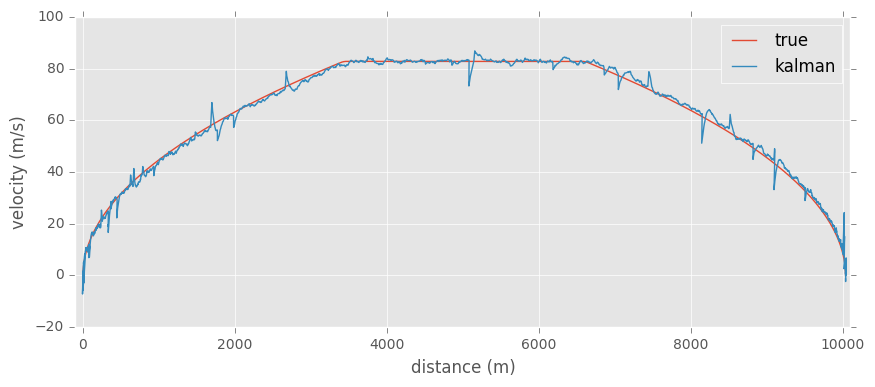

In [4]:
plt.figure(figsize=(10,4))
plt.plot(x_true[:, 0], x_true[:, 1], label='true')
plt.plot(x_pred[:, 0], x_pred[:, 1], label='kalman')
plt.legend(loc='best')
plt.xlabel('distance (m)')
plt.ylabel('velocity (m/s)')
plt.xlim([-100, 10100]);

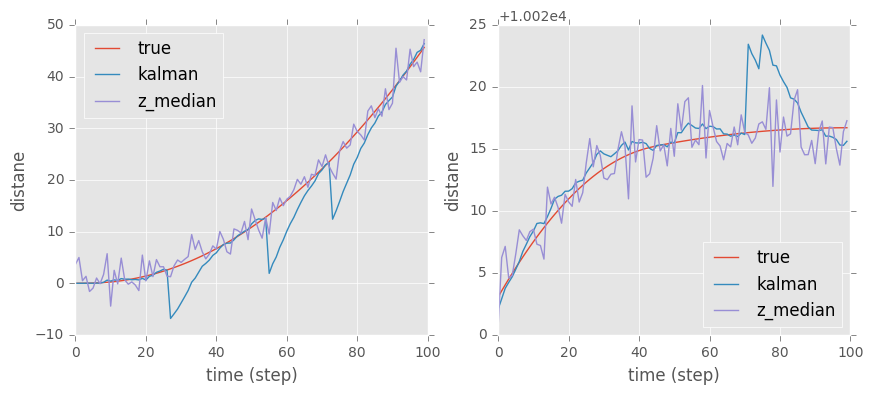

In [5]:
plt.figure(figsize=(10,4))
T = 100
plt.subplot(121)
plt.plot(range(T), x_true[:T, 0], label='true')
plt.plot(range(T), x_pred[:T, 0], label='kalman')
plt.plot(range(T), z_med[:T], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');

plt.subplot(122)
plt.plot(range(T), x_true[-T:, 0], label='true')
plt.plot(range(T), x_pred[-T:, 0], label='kalman')
plt.plot(range(T), z_med[-T:], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');

## Kalman Filter with parameter update
* 2D KF states (position, speed)
* R_v update during prediction

In [6]:
dt = 0.1
sig_w = 3.0
sig_v = 3.0
num_sensor = 3
sensor_delay = 0.01

F = np.array([[1, dt], [0, 1]])
G = np.array([dt**2/2, dt])
R_w = G*G[:, None]*sig_w**2
H = np.array([[1, -sensor_delay] for _ in range(num_sensor)])
R_v = np.eye(num_sensor)*sig_v**2

In [7]:
x = np.zeros(2)
P = np.zeros((2, 2))
train = TrainSimulator(num_sensor=num_sensor)
kalman = KalmanFilter(F, R_w, H, R_v)

x_true = []
x_pred = []
variance = []
z_med = []

while not x_true or x_true[-1][1] > 0:
    x_true.append(train.move(dt))
    z = train.measure()
    z_med.append(np.median(z))
    sig_z = np.array([sig_v**2]*num_sensor)
    for i, v in enumerate(np.abs(z - z_med[-1])):
        if v > sig_v:
            sig_z[i] = v**2
#     sig_z = np.array([((z - z_med[-1])**2).max()+sig_v**2]*num_sensor)
    R_v = np.diag(sig_z)
    x, P = kalman.predict_update(x, P, z, R_v)
    x_pred.append(x)
    variance.append([P[0,0], P[1,1]])
    
x_true = np.array(x_true)
x_pred = np.array(x_pred)
variance = np.array(variance)
z_med = np.array(z_med)

mse_zmed = ((z_med-x_true[:, 0])**2).mean()
mse_kalman_x = ((x_pred[:, 0]-x_true[:, 0])**2).mean()
mse_kalman_v = ((x_pred[:, 1]-x_true[:, 1])**2).mean()
print "z_median: MSE %.3f, res_max %.3f" %(mse_zmed, np.abs(z_med-x_true[:, 0]).max())
print "Kalman_x: MSE %.3f, res_max %.3f" %(mse_kalman_x, np.abs(x_pred[:, 0]-x_true[:, 0]).max())
print "Kalman_v: MSE %.3f, res_max %.3f" %(mse_kalman_v, np.abs(x_pred[:, 1]-x_true[:, 1]).max())

z_median: MSE 4.018, res_max 7.428
Kalman_x: MSE 0.896, res_max 2.577
Kalman_v: MSE 1.152, res_max 2.696


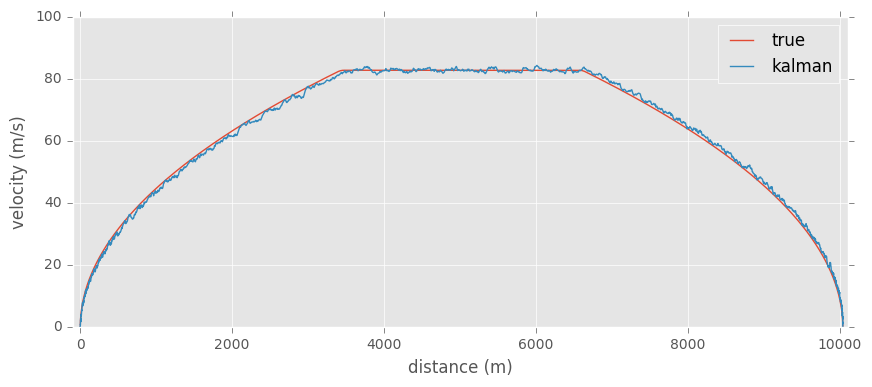

In [8]:
plt.figure(figsize=(10,4))
plt.plot(x_true[:, 0], x_true[:, 1], label='true')
plt.plot(x_pred[:, 0], x_pred[:, 1], label='kalman')
plt.legend(loc='best')
plt.xlabel('distance (m)')
plt.ylabel('velocity (m/s)')
plt.ylim([0, 100])
plt.xlim([-100, 10100]);

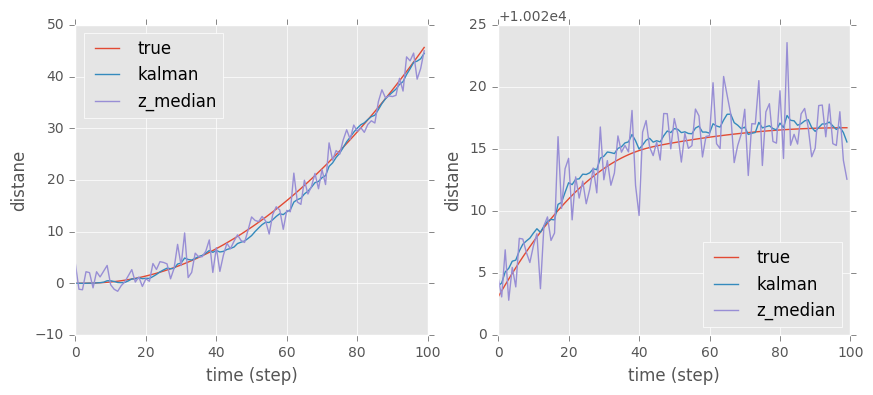

In [9]:
plt.figure(figsize=(10,4))
T = 100
plt.subplot(121)
plt.plot(range(T), x_true[:T, 0], label='true')
plt.plot(range(T), x_pred[:T, 0], label='kalman')
plt.plot(range(T), z_med[:T], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');

plt.subplot(122)
plt.plot(range(T), x_true[-T:, 0], label='true')
plt.plot(range(T), x_pred[-T:, 0], label='kalman')
plt.plot(range(T), z_med[-T:], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');

## Kalman Filter with 3D state space
* 3D KF states (position, speed, acceleration)
* R_v update during prediction

In [40]:
dt = 0.1
sig_w = 0.1
sig_v = 3.0
num_sensor = 3
sensor_delay = 0.01

F = np.array([[1, dt, dt**2/2], [0, 1, dt], [0, 0, 1]])
G = np.array([dt**2/2, dt, 1.0])
R_w = G*G[:, None]*sig_w**2
H = np.array([[1, -sensor_delay, 0] for _ in range(num_sensor)])
R_v = np.eye(num_sensor)*sig_v**2

In [41]:
x = np.zeros(3)
P = np.zeros((3, 3))
train = TrainSimulator(num_sensor=num_sensor)
kalman = KalmanFilter(F, R_w, H, R_v)

x_true = []
x_pred = []
variance = []
z_med = []
dev = []

while not x_true or x_true[-1][1] > 0:
    x_true.append(train.move(dt))
    z = train.measure()
    z_med.append(np.median(z))
    sig_z = np.maximum(np.abs(z - z_med[-1]), max(sig_v, np.median(np.abs(z - z_med[-1]))))
    R_v = np.diag(sig_z**2)
    dev.append(sig_z.min())
    x, P = kalman.predict_update(x, P, z, R_v)
    x_pred.append(x)
    variance.append([P[0,0], P[1,1]])
    
x_true = np.array(x_true)
x_pred = np.array(x_pred)
variance = np.array(variance)
z_med = np.array(z_med)

mse_zmed = ((z_med-x_true[:, 0])**2).mean()
mse_kalman_x = ((x_pred[:, 0]-x_true[:, 0])**2).mean()
mse_kalman_v = ((x_pred[:, 1]-x_true[:, 1])**2).mean()
print "z_median: MSE %.3f, res_max %.3f" %(mse_zmed, np.abs(z_med-x_true[:, 0]).max())
print "Kalman_x: MSE %.3f, res_max %.3f" %(mse_kalman_x, np.abs(x_pred[:, 0]-x_true[:, 0]).max())
print "Kalman_v: MSE %.3f, res_max %.3f" %(mse_kalman_v, np.abs(x_pred[:, 1]-x_true[:, 1]).max())

z_median: MSE 4.017, res_max 7.832
Kalman_x: MSE 0.826, res_max 2.695
Kalman_v: MSE 0.312, res_max 1.860


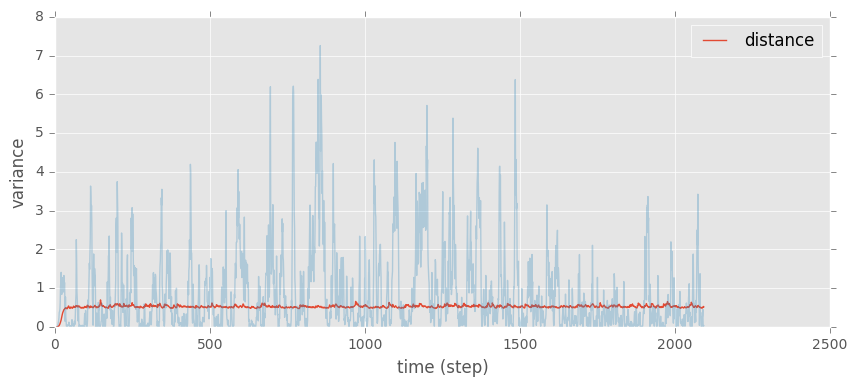

In [42]:
plt.figure(figsize=(10,4))
plt.plot(range(len(z_med)), variance[:, 0], label='distance')
plt.plot(range(len(z_med)), (x_pred[:, 0]-x_true[:, 0])**2, alpha=0.3)
# plt.plot(range(len(z_med)), dev, alpha=0.3)

plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('variance');

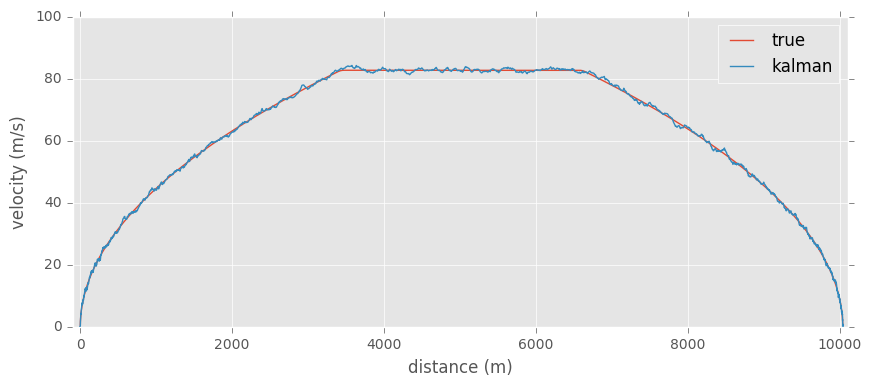

In [43]:
plt.figure(figsize=(10,4))
plt.plot(x_true[:, 0], x_true[:, 1], label='true')
plt.plot(x_pred[:, 0], x_pred[:, 1], label='kalman')
plt.legend(loc='best')
plt.xlabel('distance (m)')
plt.ylabel('velocity (m/s)')
plt.ylim([0, 100])
plt.xlim([-100, 10100]);

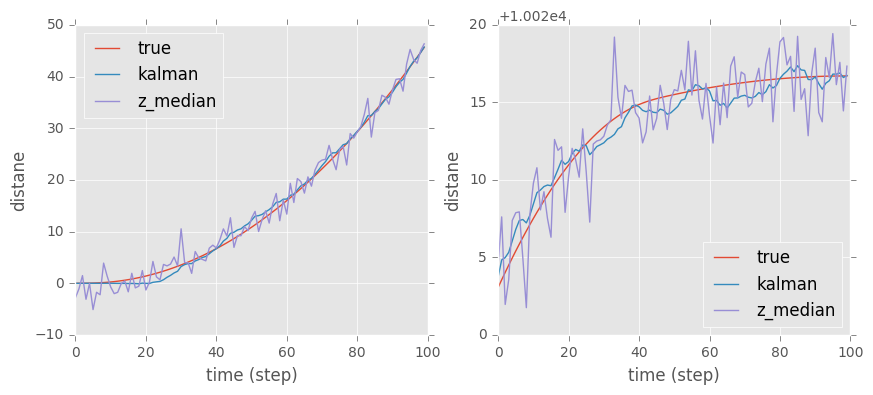

In [19]:
plt.figure(figsize=(10,4))
T = 100
plt.subplot(121)
plt.plot(range(T), x_true[:T, 0], label='true')
plt.plot(range(T), x_pred[:T, 0], label='kalman')
plt.plot(range(T), z_med[:T], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');

plt.subplot(122)
plt.plot(range(T), x_true[-T:, 0], label='true')
plt.plot(range(T), x_pred[-T:, 0], label='kalman')
plt.plot(range(T), z_med[-T:], label='z_median')
plt.legend(loc='best')
plt.xlabel('time (step)')
plt.ylabel('distane');